# Homework 4

The purpose of the fourth homework is to become familiar with Ceteris Paribus (CP) and Partial Dependence profiles (PDP), and its variants like Accumulated Local Effects (ALE).

Calculate these explanations on the model from previous Homeworks and gather conclusions from the results.

In [ ]:
! pip install dalex
! pip install alibi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 8.3 MB/s 
  Created wheel for dalex: filename=dalex-1.5.0-py3-none-any.whl size=1043319 sha256=9e6da62635ab14695a7ff4564414ba634c14b8be1ef2b7e406f47f6bcdd2146f
  Stored in directory: /root/.cache/pip/wheels/76/31/8c/c78df586df31b3f3e0c4ecc759ee73e175545cff5548201996
Successfully built dalex
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 472 kB 10.3 MB/s 
     |████████████████████████████████| 5.5 MB 50.7 MB/s 
     |████████████████████████████████| 98.5 MB 112 kB/s 
     |████████████████████████████████| 182 kB 41.2 MB/s 
     |████████████████████████████████| 7.6 MB 39.2 MB/s 


In [ ]:
import pickle
import xgboost
import numpy as np
import dalex as dx
import pandas as pd

from alibi.explainers import PartialDependence, plot_pd
from sklearn.model_selection import train_test_split

## Task 1
Consider a following model:

$f(x_{1}, x_{2}) = (x_{1} + x_{2})^2$

Assume that $x_{1}, x_{2} ~ U[-1,1]$ and $x_{1} = x_{2}$ (full dependency)

In [ ]:
x = np.random.uniform(-1.0, 1.0, 500)
df = pd.DataFrame()
df['x1'] = x
df['x2'] = x
f = (x + x) ** 2

X_train, X_test, y_train, y_test = train_test_split(df, f, test_size=0.25, random_state=420)
df

,x1,x2
0,-0.027831,-0.027831
1,-0.263416,-0.263416
2,-0.614724,-0.614724
3,-0.213486,-0.213486
4,-0.792989,-0.792989
...,...,...
495,0.200489,0.200489
496,0.098757,0.098757
497,-0.264820,-0.264820
498,0.081110,0.081110


In [ ]:
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)

[21:57:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

Calculate PD profile for variable $x_{1}$ in this model.

In [ ]:
explainer = dx.Explainer(model, X_test, y_test)
cp = explainer.predict_profile(new_observation=X_test.iloc[1])
cp

Preparation of a new explainer is initiated

  -> data              : 125 rows 2 cols
  -> target variable   : 125 values
  -> model_class       : xgboost.sklearn.XGBRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7fb5da513200> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.00936, mean = 1.27, max = 3.9
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.0657, mean = 0.000972, max = 0.0646
  -> model_info        : package xgboost

A new explainer has been created!


Calculating ceteris paribus: 100%|██████████| 2/2 [00:00<00:00, 119.06it/s]


,x1,x2,_original_,_yhat_,_vname_,_ids_,_label_
1,-0.980966,-0.263416,-0.263416,3.842021,x1,1,XGBRegressor
1,-0.961293,-0.263416,-0.263416,3.677212,x1,1,XGBRegressor
1,-0.941621,-0.263416,-0.263416,3.605178,x1,1,XGBRegressor
1,-0.921948,-0.263416,-0.263416,3.384696,x1,1,XGBRegressor
1,-0.902275,-0.263416,-0.263416,3.256735,x1,1,XGBRegressor
...,...,...,...,...,...,...,...
1,-0.263416,0.907616,-0.263416,0.258803,x2,1,XGBRegressor
1,-0.263416,0.927289,-0.263416,0.258803,x2,1,XGBRegressor
1,-0.263416,0.946962,-0.263416,0.258803,x2,1,XGBRegressor
1,-0.263416,0.966634,-0.263416,0.258803,x2,1,XGBRegressor


In [ ]:
cp.plot(variables=["x1"])

Extra task if you do not fear conditional expected values: Calculate ME and ALE profiles for variable $x_{1}$ in this model.

In [ ]:
ale_num = explainer.model_profile(type="ale", variables=['x1'], center=False)
ale_num.plot(title="Accumulated Local Effects")

Calculating accumulated dependency: 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


## Task 2

0. For the selected data set, train at least one tree-based ensemble model, e.g. random forest, gbdt, xgboost.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
p = "/content/drive/MyDrive/Colab Notebooks/XAI/"
#p = "../HW3/AnnaSemik/"

X_train = pd.read_csv(p+"X_train.csv", index_col=0)
X_test = pd.read_csv(p+"X_train.csv", index_col=0)
y_train = pd.read_csv(p+"y_train.csv", index_col=0)
y_test = pd.read_csv(p+"y_test.csv", index_col=0)

lreg_model = pickle.load(open(p+"logistic_regression_model.sav", 'rb'))
boosting_model = xgboost.Booster()
boosting_model.load_model(p+"boosting_model.txt")
rf_model = pickle.load(open(p+"random_forest_model.sav", 'rb'))

1. Calculate the predictions for some selected observations.

In [ ]:
obs = X_train.iloc[[3, 33, 222],]

po = obs.copy()

obs_preds_lreg = lreg_model.predict(obs)
obs_preds_boosting = boosting_model.predict(xgboost.DMatrix(obs))
obs_preds_rf = rf_model.predict(obs)

po['pred_lreg'] = obs_preds_lreg
po['pred_rf'] = obs_preds_rf

In [ ]:
vars = ['age','Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
        'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2']
vars

['age',
 'Medu',
 'Fedu',
 'traveltime',
 'studytime',
 'failures',
 'famrel',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health',
 'absences',
 'G1',
 'G2']

2. Then, calculate the what-if explanations of these predictions using Ceteris Paribus profiles (also called What-if plots).
(*implement CP yourself for a potential bonus point*)

In [ ]:
explainer = dx.Explainer(rf_model, X_train, y_train)
cp = explainer.predict_profile(new_observation=po[po.columns[:32]])
cp.plot(title=str(obs_preds_rf), variables=vars)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



Preparation of a new explainer is initiated

  -> data              : 296 rows 32 cols
  -> target variable   : Parameter 'y' was a pandas.DataFrame. Converted to a numpy.ndarray.
  -> target variable   : 296 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x7fb5da513200> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 10.6, max = 19.4
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -3.24, mean = 0.0155, max = 2.45
  -> model_info        : package sklearn

A new explainer has been created!


Calculating ceteris paribus: 100%|██████████| 32/32 [00:00<00:00, 63.37it/s]


3. Find two observations in the data set, such that they have different CP profiles. For example, model predictions are increasing with age for one observation and decreasing with age for another one. NOTE that you will need to have a model with interactions to observe such differences.

In [ ]:
#explainer = dx.Explainer(rf_model, X_train, y_train)
cp = explainer.predict_profile(new_observation=X_train[X_train['G2']==10][32:34])
cp.plot(title=str(X_train[X_train['G2']==10][32:34]['G2'].values), variables=['G2'])

Calculating ceteris paribus: 100%|██████████| 32/32 [00:00<00:00, 69.33it/s]


In [ ]:
X_train

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
344,0,0,18,1,0,1,2,3,0,2,...,0,4,3,3,1,2,3,4,11,10
341,0,1,18,1,0,1,4,4,4,3,...,0,4,3,3,2,2,2,0,10,10


5. Compare PDP between between at least two different models.

In [ ]:
pd_lreg = PartialDependence(predictor=lreg_model.predict, feature_names=list(po.columns[:32].values), target_names='pred_lreg')
pd_rf = PartialDependence(predictor=rf_model.predict, feature_names=list(po.columns[:32].values), target_names='pred_rf')

exp_lreg = pd_lreg.explain(X=np.array(X_train));
exp_rf = pd_rf.explain(X=np.array(X_train));

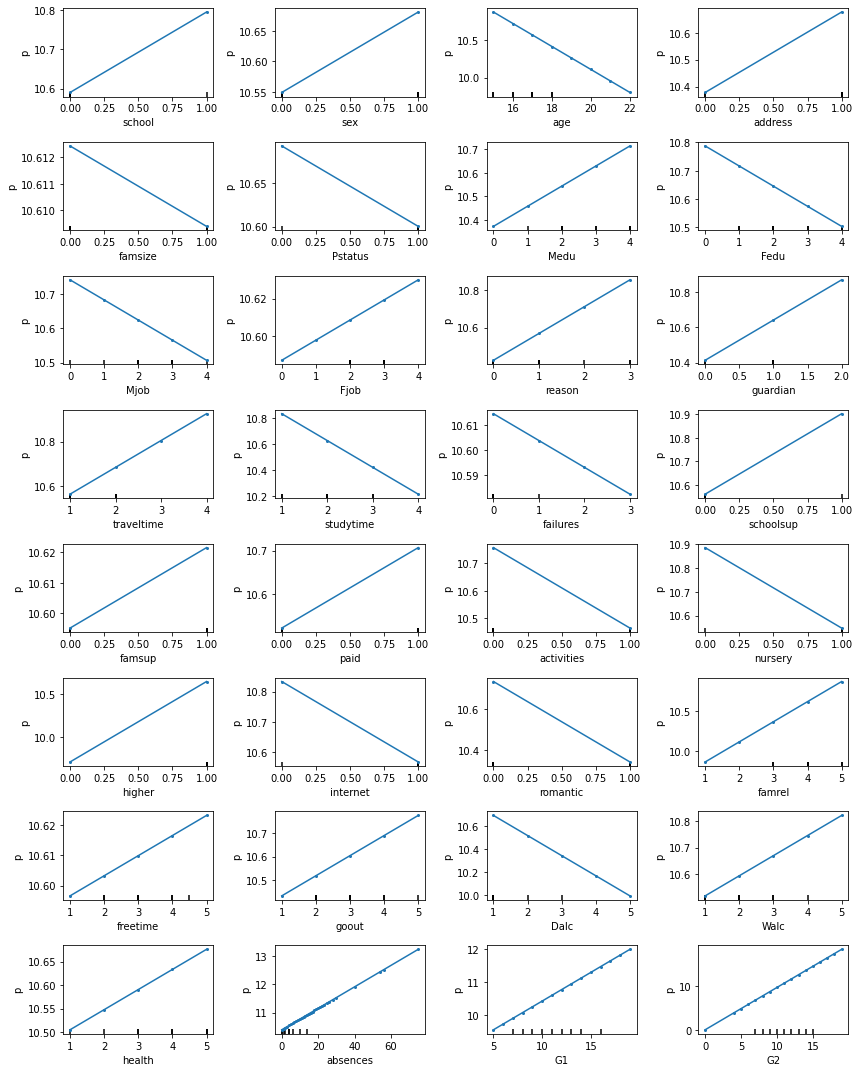

In [ ]:
plot_pd(exp_lreg, n_cols=4, sharey=None, fig_kw={'figheight': 15, 'figwidth': 12});

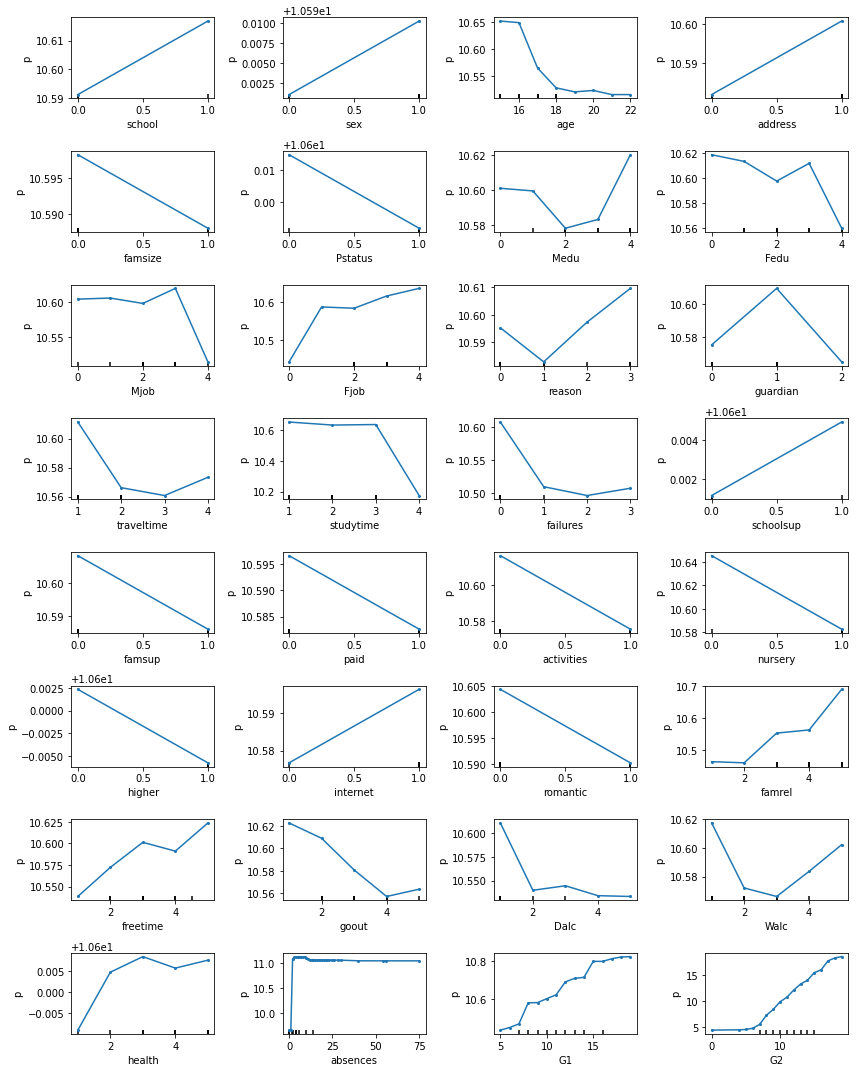

In [ ]:
plot_pd(exp_rf, n_cols=4, sharey=None, fig_kw={'figheight': 15, 'figwidth': 12});

6. COMMENT on the results obtained in (2)-(5)